In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()


import re
import string

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.feature_extraction.text import TfidfTransformer


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

## Load Corpus and Look at the Data

In [2]:
df = pd.read_csv("data/balanced_data_combined.csv")
df = df.drop(columns = 'Unnamed: 0')

In [3]:
df.shape

(8337, 2)

In [4]:
df.head()

,text,class
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [5]:
# class 0 - not hate speech
# class 1 - hate speech

In [6]:
df['class_descr'] = df['class'].map(lambda x: 'hate_speech' if x==1 else 'not_hate_speech')

In [7]:
df['class'].value_counts()

1    4174
0    4163
Name: class, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8337 entries, 0 to 8336
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         8335 non-null   object
 1   class        8337 non-null   int64 
 2   class_descr  8337 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.5+ KB


In [9]:
# Drop NaN values in text column

df.dropna(subset=['text'], inplace=True)

In [10]:
conditions = [ df['class'] == 0 ,df['class'] == 1 ,df['class'] == 2]
choises = ['hate_speech', 'not_hate_speech', 'not_hate_speech']

df['class_description'] = np.select(conditions, choises)

# Document - Term Matrix
- Preprotcessing and cleaning
- Tokenize
- Stemming and Lemming
- Document-Term Matrix

## Data Preprotcessing and Cleaning

In [11]:
# removing excess
# removing punctuation
# lovercase letters 
# remove numbers or numerical values
# remove non-sesial text (/n)

In [12]:
# Create function with text cleaning techniques usinx regex

def clean_text_step1(text):
    '''
    Looking for speciffic patterns in the text and 
    removing them or replacing with space
    Function returns string
    '''
        
    # make text lowercase
    text = text.lower()
    
    # string punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    
    # removing patterns and replace it with nothing
    text = re.sub('\[.*?\]', '', text)
 
    # removing digits if they surounded with text or digit
    text = re.sub('\w*\d\w*', '', text)
    
    # make just 1 space if there is more then 1
    text = re.sub('\s+', ' ', text)
    
    # replace new line symbol with space
    text = re.sub('\n', ' ', text)
    
    # removing any quotes
    text = re.sub('\"+', '', text)
    
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    
    # cleaning from user name
    text = re.sub('(@[^\s]+)', '', text)
    
    # looking for # and replacing it
    text = re.sub('(#[^\s]+)', '', text)
    
    # removing `rt`
    text = re.sub('(rt)', '', text)

    # looking for `httptco`
    text = re.sub('(httptco)', '', text)
    
    # looking for `mkr`
    text = re.sub('(mkr)', '', text)
    
    text = re.sub('(sexist)', '', text)

    return text

In [13]:
# applying function for cleaning text data
df['text'] = df['text'].apply(clean_text_step1)

In [14]:
df.head()

,text,class,class_descr,class_description
0,drasko they didnt cook half a bird you idiot,1,hate_speech,not_hate_speech
1,hopefully someone cooks drasko in the next ep of,1,hate_speech,not_hate_speech
2,of course you were born in serbiayoure as fuck...,1,hate_speech,not_hate_speech
3,these girls are the equivalent of the irritati...,1,hate_speech,not_hate_speech
4,yesyoureracist at least youre only a tiny bit...,1,hate_speech,not_hate_speech


## Tokenization Data (splitting into smaller pieces) and removing stopwords

In [15]:
stopwords_list = stopwords.words('english')

In [16]:
def tokenize_text(text):
    
    """
    Tocanize document and create visualization of most recent words
    Wiil filter data with stopwords
    """
    tokens = nltk.word_tokenize(text)
    
    stopwords_removed = [token for token in tokens if token not in stopwords_list] 
    
    return stopwords_removed

In [17]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
processed_data = list(map(tokenize_text, df['text']))

## Plot frequency distribution of tokens in corpus

In [19]:
def plot_frequency(data):
    """
    Ploting words frequency distribution
    from corpus. data should be list of lists with strings
    """
    words_lst = []
    for tweet in data:
        for word in tweet:
            words_lst.append(word)

    fdist = FreqDist(words_lst)
    plt.figure(figsize=(10,6))
    fdist.plot(30)
    plt.show()

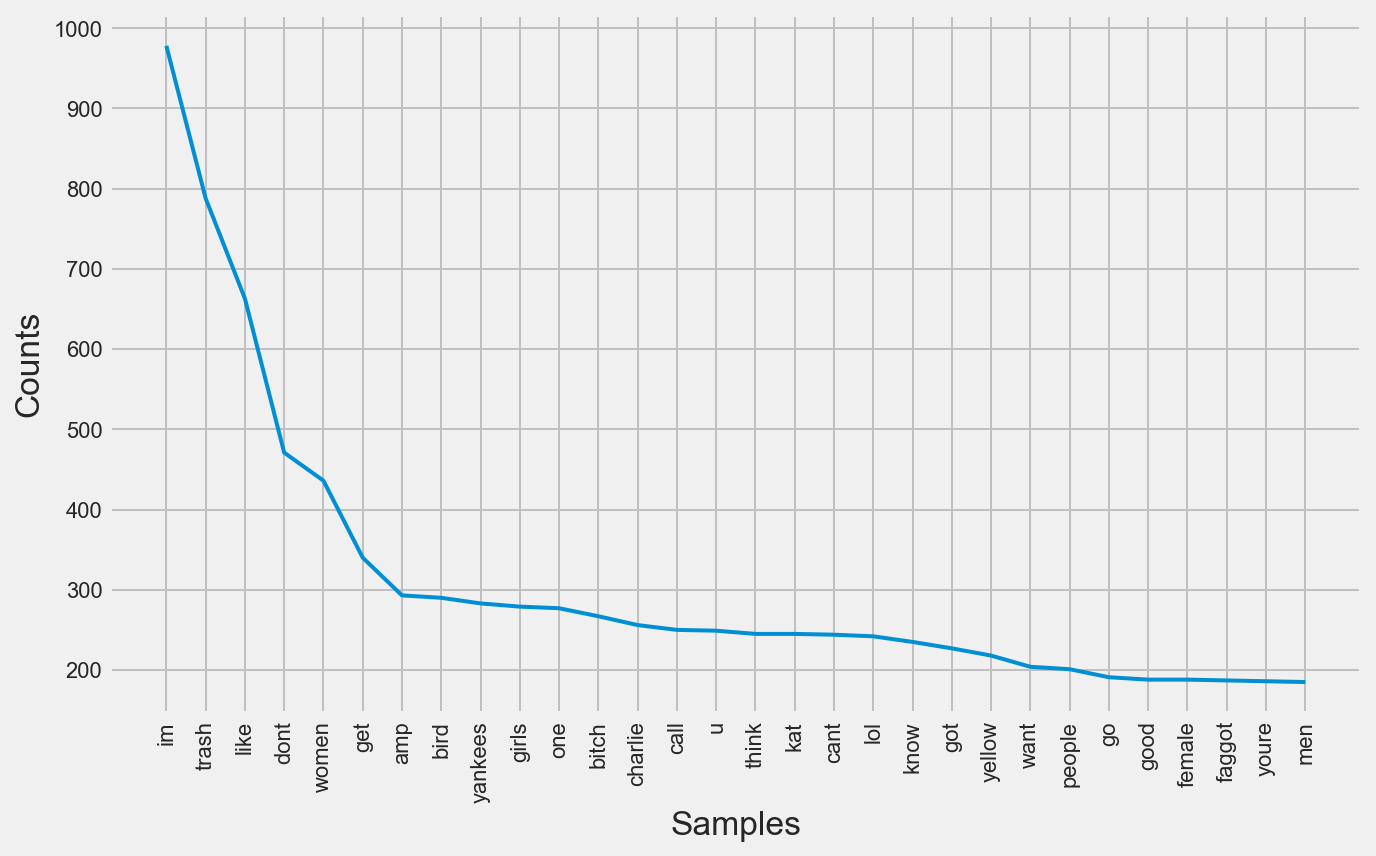

In [20]:
plot_frequency(processed_data)

In [21]:
processed_data[:2]

[['drasko', 'didnt', 'cook', 'half', 'bird', 'idiot'],
 ['hopefully', 'someone', 'cooks', 'drasko', 'next', 'ep']]

In [22]:
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

18286

## Create Docunent-Term Matrix 

In [23]:
# look at the corpus
df.head()

,text,class,class_descr,class_description
0,drasko they didnt cook half a bird you idiot,1,hate_speech,not_hate_speech
1,hopefully someone cooks drasko in the next ep of,1,hate_speech,not_hate_speech
2,of course you were born in serbiayoure as fuck...,1,hate_speech,not_hate_speech
3,these girls are the equivalent of the irritati...,1,hate_speech,not_hate_speech
4,yesyoureracist at least youre only a tiny bit...,1,hate_speech,not_hate_speech


In [24]:
# Using CountVextorizer from sklearn 
# in data_dtm each row represents different document
# and each collumn represents word from vocab

cv = CountVectorizer(stop_words = 'english')
df_cv = cv.fit_transform(df.text)
data_dtm = pd.DataFrame(df_cv.toarray(), columns= cv.get_feature_names())
data_dtm.index = df.index
data_dtm.head()

,aa,aaaaaaaaand,aaand,aamaadmipay,aamattyhealy,aamessinger,aan,aandapples,aap,aarcayne,...,zstonecipher,ztsupreme,zucchini,zwaaad,zwithr,zyhosbrfff,zzachbarness,zzzquil,zzzz,zzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Lematizing Data

In [25]:
#creating a list with all lemmatized outputs

def lematizing_text(data):
    
    """
    Lematizing words from the corpus data
    Returns list of strings with lematized 
    words in each string
    """
    
    lemmatizer = WordNetLemmatizer() 
    lemmatized_output = []

    for tweet in data:
        lemmed = ' '.join([lemmatizer.lemmatize(w) for w in tweet])
        lemmatized_output.append(lemmed)
        
    return lemmatized_output

In [26]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
lemmatized_data = lematizing_text(processed_data)

In [28]:
lemmatized_data[:5]

['drasko didnt cook half bird idiot',
 'hopefully someone cook drasko next ep',
 'course born serbiayoure fucked serbian film',
 'girl equivalent irritating asian girl couple year ago well done',
 'yesyoureracist least youre tiny bit racist im racist dick']

## Most Frequent Words for Each Class

In [29]:
df_freq_hate = df[df['class']==1]
df_freq_not_hate = df[df['class']==0]

In [30]:
data_hate = df_freq_hate['text']
data_not_hate = df_freq_not_hate['text']

In [31]:
def freq_wrds_class(data, n = 20, show= True):
    
    """
    Returns list of 2 tuples that represents frequency
    of words in document
    
    data - Series with string data
    n - number of most common words to show
    """
    
    protc_data = list(map(tokenize_text, data))
    
    total_vocab = set()
    for comment in protc_data:
        total_vocab.update(comment)
    
    if show:
        print('Total words in vocab : {}'.format(len(total_vocab)))
        print (30*'-')
        print('Top {} most frequent words:'.format(n))
        flat_data = [item for sublist in protc_data for item in sublist]
        freq = FreqDist(flat_data)
        return freq.most_common(n)
    flat_data = [item for sublist in protc_data for item in sublist]
    freq = FreqDist(flat_data)
    
    return freq

In [32]:
# Top 20 hate words:

freq_wrds_class(data_hate, show=True)

Total words in vocab : 9901
------------------------------
Top 20 most frequent words:


[('im', 761),
 ('women', 422),
 ('like', 362),
 ('dont', 302),
 ('bitch', 257),
 ('girls', 244),
 ('kat', 244),
 ('call', 210),
 ('get', 196),
 ('faggot', 187),
 ('think', 178),
 ('female', 176),
 ('fuck', 172),
 ('cant', 170),
 ('men', 164),
 ('ass', 152),
 ('one', 147),
 ('know', 146),
 ('u', 140),
 ('nigga', 139)]

In [33]:
 #Top 20 non-hate words:

freq_wrds_class(data_not_hate)

Total words in vocab : 11882
------------------------------
Top 20 most frequent words:


[('trash', 672),
 ('like', 301),
 ('bird', 287),
 ('yankees', 281),
 ('charlie', 256),
 ('im', 217),
 ('yellow', 213),
 ('dont', 169),
 ('birds', 167),
 ('amp', 166),
 ('get', 144),
 ('lol', 140),
 ('got', 131),
 ('one', 130),
 ('monkey', 111),
 ('ghetto', 109),
 ('u', 109),
 ('colored', 108),
 ('good', 94),
 ('know', 89)]

## Normalized word frequencies:

In [34]:
def normalized_word_fqncy(data, n=25):
    
    frqncy = freq_wrds_class(data, n, show = False)
    total_w_count = sum(frqncy.values())
    top = frqncy.most_common(25)
    print("Word \t\t Normalized Frequency")
    print()
    for word in top:
        normalized_frequency = word[1]/ total_w_count
        print("{} \t\t {:.4}".format(word[0], normalized_frequency))

In [35]:
normalized_word_fqncy(data_hate)

Word 		 Normalized Frequency

im 		 0.02106
women 		 0.01168
like 		 0.01002
dont 		 0.008356
bitch 		 0.007111
girls 		 0.006752
kat 		 0.006752
call 		 0.005811
get 		 0.005423
faggot 		 0.005174
think 		 0.004925
female 		 0.00487
fuck 		 0.004759
cant 		 0.004704
men 		 0.004538
ass 		 0.004206
one 		 0.004068
know 		 0.00404
u 		 0.003874
nigga 		 0.003846
woman 		 0.003791
white 		 0.00368
fucking 		 0.003652
hate 		 0.003542
amp 		 0.003514


In [36]:
normalized_word_fqncy(data_not_hate)

Word 		 Normalized Frequency

trash 		 0.01846
like 		 0.008267
bird 		 0.007882
yankees 		 0.007718
charlie 		 0.007031
im 		 0.00596
yellow 		 0.00585
dont 		 0.004642
birds 		 0.004587
amp 		 0.004559
get 		 0.003955
lol 		 0.003845
got 		 0.003598
one 		 0.00357
monkey 		 0.003049
ghetto 		 0.002994
u 		 0.002994
colored 		 0.002966
good 		 0.002582
know 		 0.002444
new 		 0.002417
go 		 0.002389
love 		 0.002307
day 		 0.002307
game 		 0.00228


## Visualization 

In [37]:
hate_freq = freq_wrds_class(data_hate, show =False)
not_hate_freq = freq_wrds_class(data_not_hate, show =False)

In [38]:
# create counts of hate and not hate with values and words
hate_bar_counts = [x[1] for x in hate_freq.most_common(25)]
hate_bar_words = [x[0] for x in hate_freq.most_common(25)]

not_hate_bar_counts = [x[1] for x in not_hate_freq.most_common(25)]
not_hate_bar_words = [x[0] for x in not_hate_freq.most_common(25)]

In [39]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

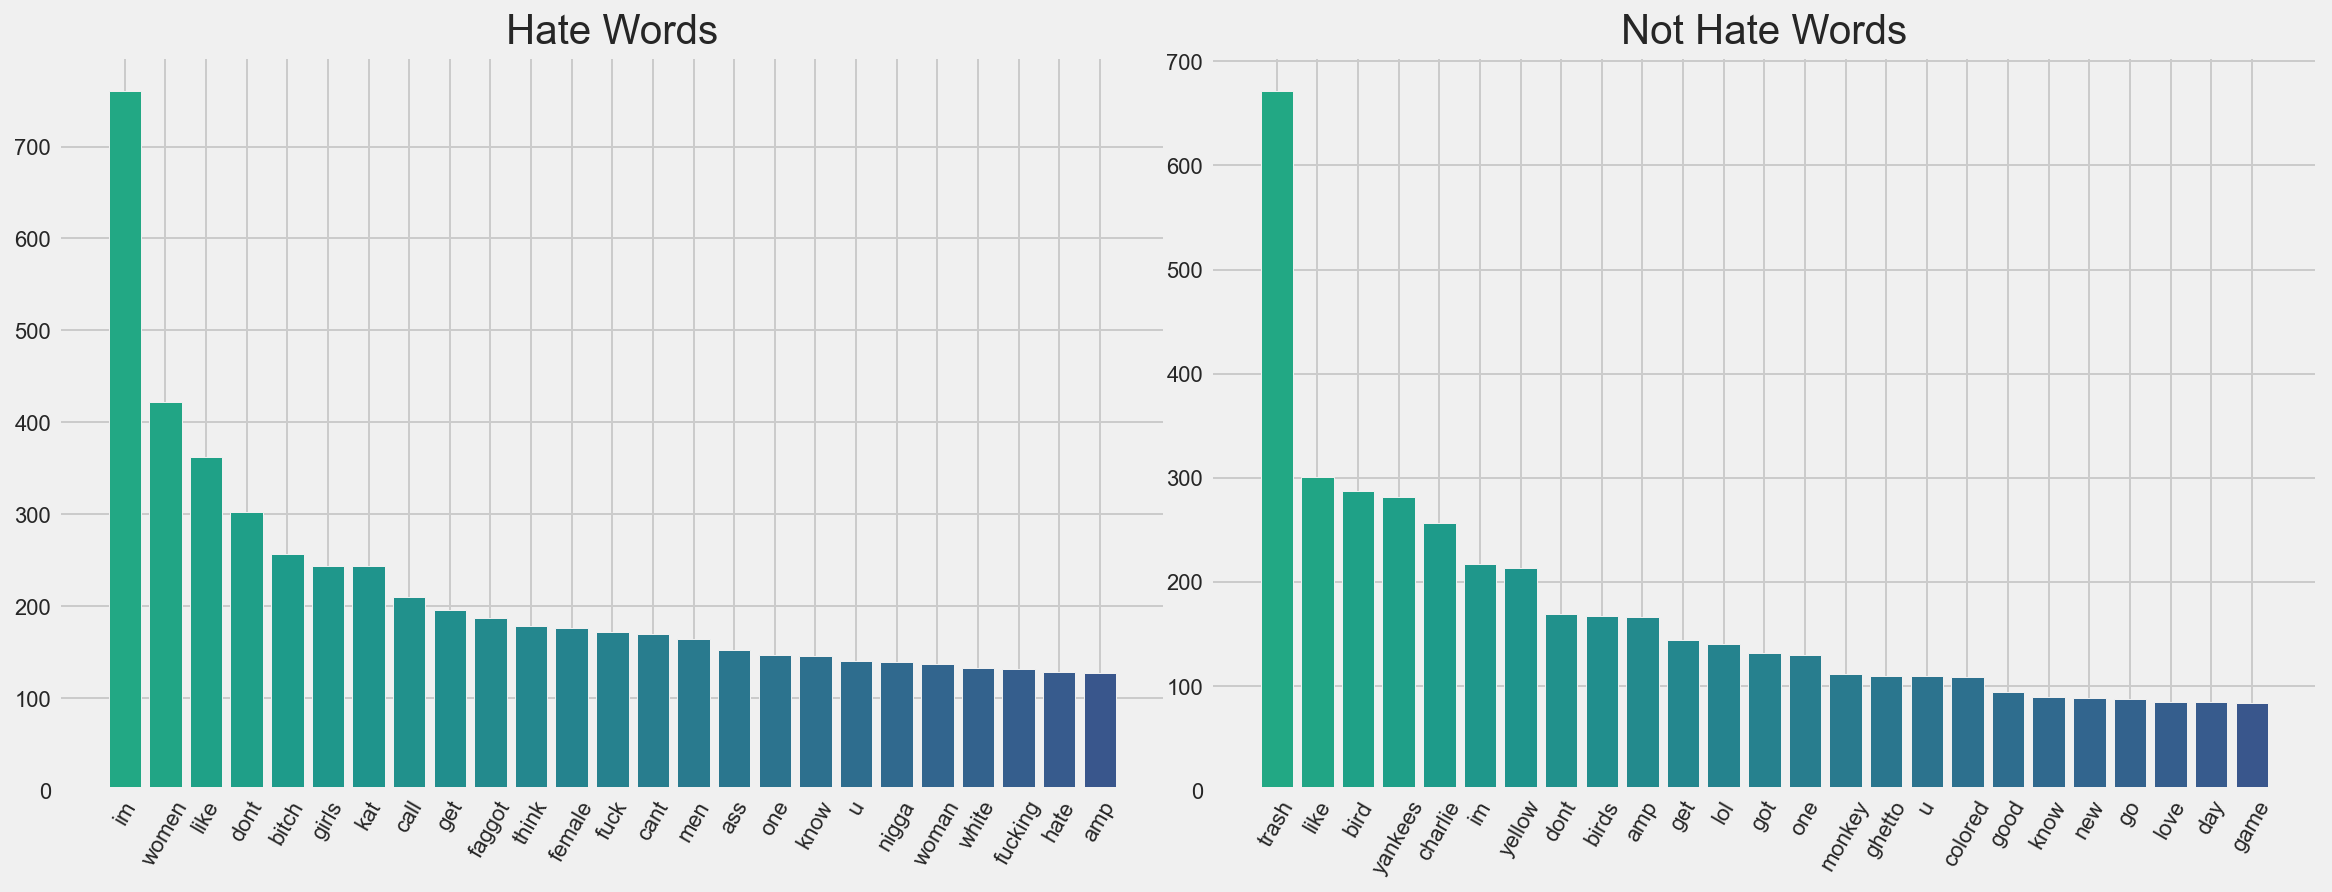

In [40]:
new_figure = plt.figure(figsize=(16,6))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(hate_bar_words, hate_bar_counts, color=color)
#ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_hate_bar_words, not_hate_bar_counts, color=color )

ax.title.set_text('Hate Words')
ax2.title.set_text('Not Hate Words')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

## Word Clouds 

In [41]:
hate_dictionary = dict(zip(hate_bar_words, hate_bar_counts))
not_hate_dictionary = dict(zip(not_hate_bar_words, not_hate_bar_counts))

In [42]:
def wordcloud(dic, save = False, name = None):
    
    
    wordcloud = WordCloud(colormap='Spectral', background_color='black').generate_from_frequencies(dic)

    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    if save :
        plt.savefig('images/{}_wordcloud.png'.format(name))

    return plt.show()

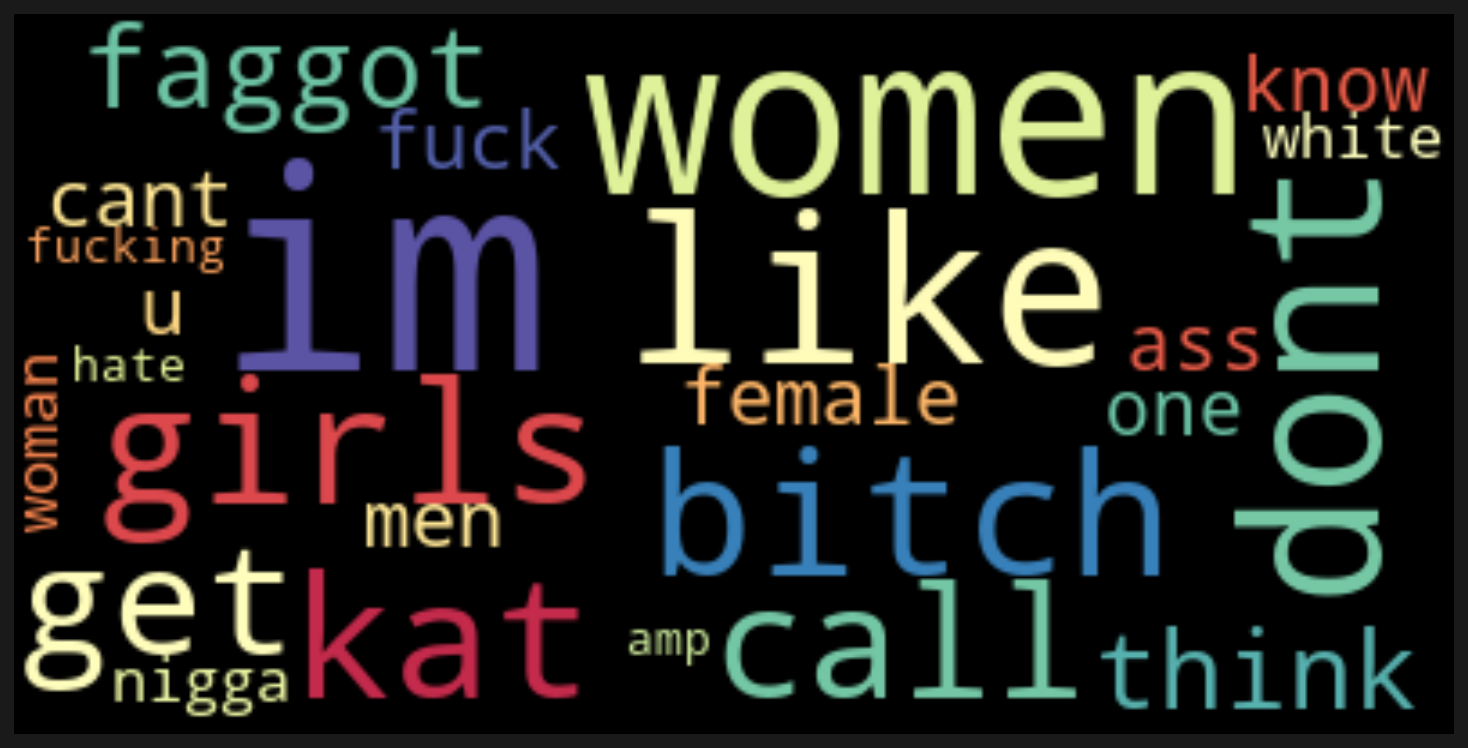

In [43]:
wordcloud(hate_dictionary, save = True, name = 'hate_speech')

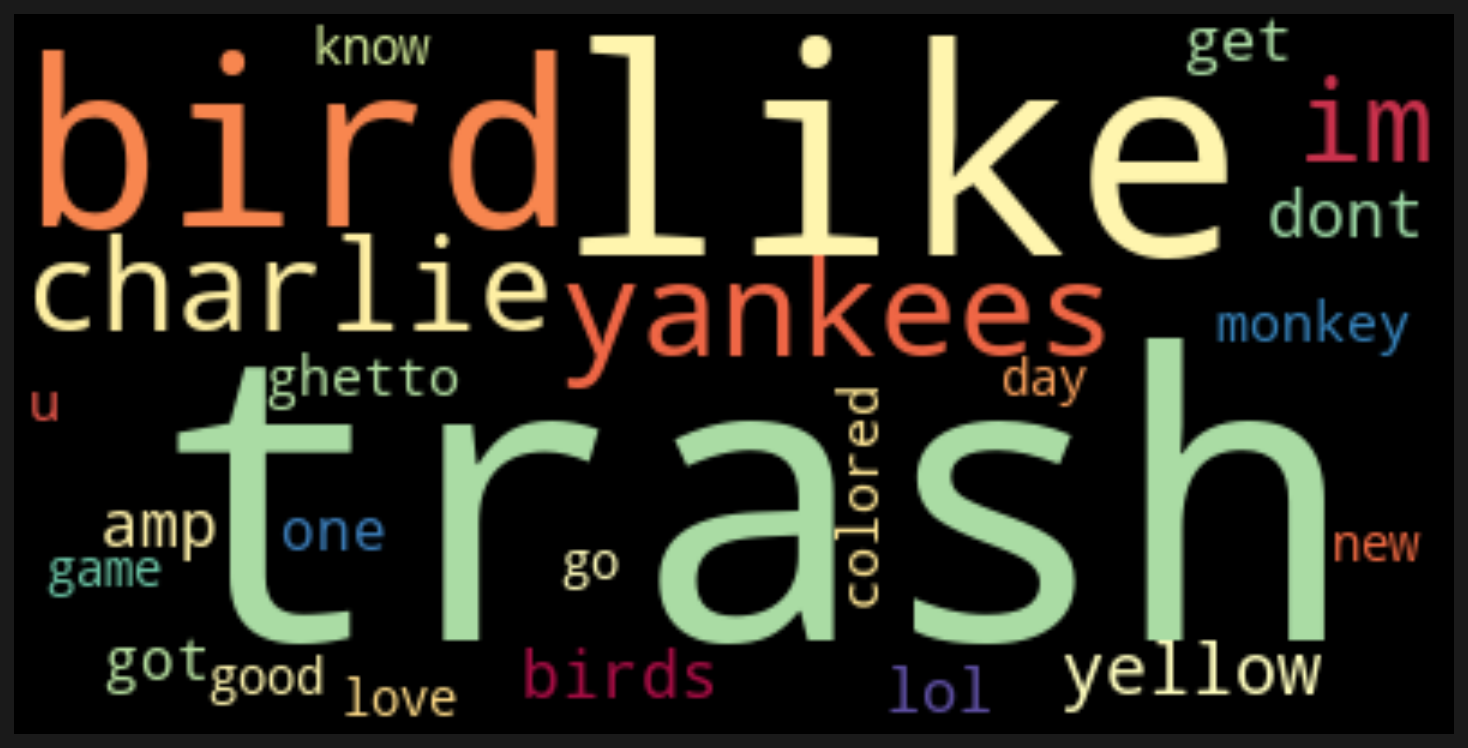

In [44]:
wordcloud(not_hate_dictionary, save = True, name = 'not_hate_speech')

# Baseline Models

## Train-Test Split & Vectorize 

In [45]:
X_lem = lemmatized_data
y_lem = df['class']

In [46]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)
tfidf = TfidfVectorizer()  # can add unigram , add stop words possible

tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)  # make sure in train
tfidf_data_test_lem = tfidf.transform(X_test_lem)   # make sure on test

tfidf_data_train_lem

<6668x14604 sparse matrix of type '<class 'numpy.float64'>'
	with 55757 stored elements in Compressed Sparse Row format>

In [47]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Tweets: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Tweets: 8.361877624475104
Percentage of columns containing ZERO: 0.9994274255255768


## 99.9% of the columns contain a zero, meaning that's a very sparse matrix 

In [48]:
# Lets Keep All models Results in dictionary for future visualization
eval_metrics_dict = {}

## Random Forest Baseline

In [49]:
rf_classifier_lem = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)
rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [50]:
rf_precision = precision_score(y_test_lem, rf_test_preds_lem)
rf_recall = recall_score(y_test_lem, rf_test_preds_lem)
rf_acc_score = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_f1_score = f1_score(y_test_lem, rf_test_preds_lem)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(rf_precision))
print('Recall: {:.4}'.format(rf_recall))

print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.8685
Recall: 0.9285
Testing Accuracy: 0.895
F1 Score: 0.8975


Text(29.973124999999982, 0.5, 'predicted label')

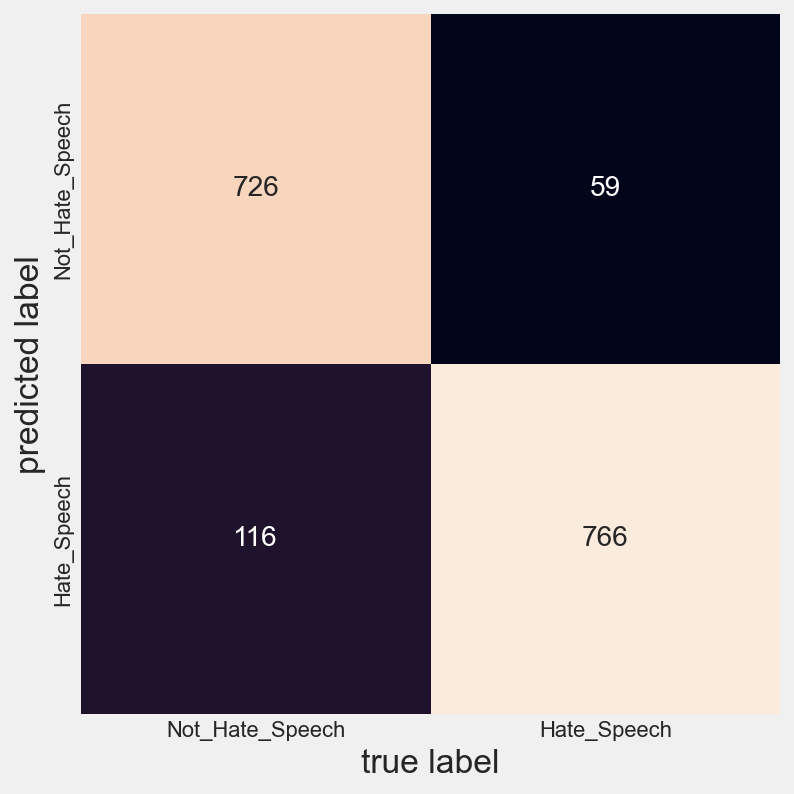

In [51]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')

In [52]:
eval_metrics_dict['Random Forest Baseline'] = {'precision' : '{:.4}'.format(rf_precision), 'recall': '{:.4}'.format(rf_recall), 'f1-score': '{:.4}'.format(rf_f1_score) }

## Logistic Regression Baseline

In [53]:
logreg = LogisticRegression(random_state = 32)
logreg.fit(tfidf_data_train_lem, y_train_lem)
logreg_test_preds = logreg.predict(tfidf_data_test_lem)

In [54]:
log_precision = precision_score(y_test_lem, logreg_test_preds)
log_recall = recall_score(y_test_lem, logreg_test_preds)
log_acc_score = accuracy_score(y_test_lem, logreg_test_preds)
log_f1_score = f1_score(y_test_lem, logreg_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(log_precision))
print('Recall: {:.4}'.format(log_recall))

print("Testing Accuracy: {:.4}".format(log_acc_score))
print("F1 Score: {:.4}".format(log_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.9012
Recall: 0.8848
Testing Accuracy: 0.895
F1 Score: 0.893


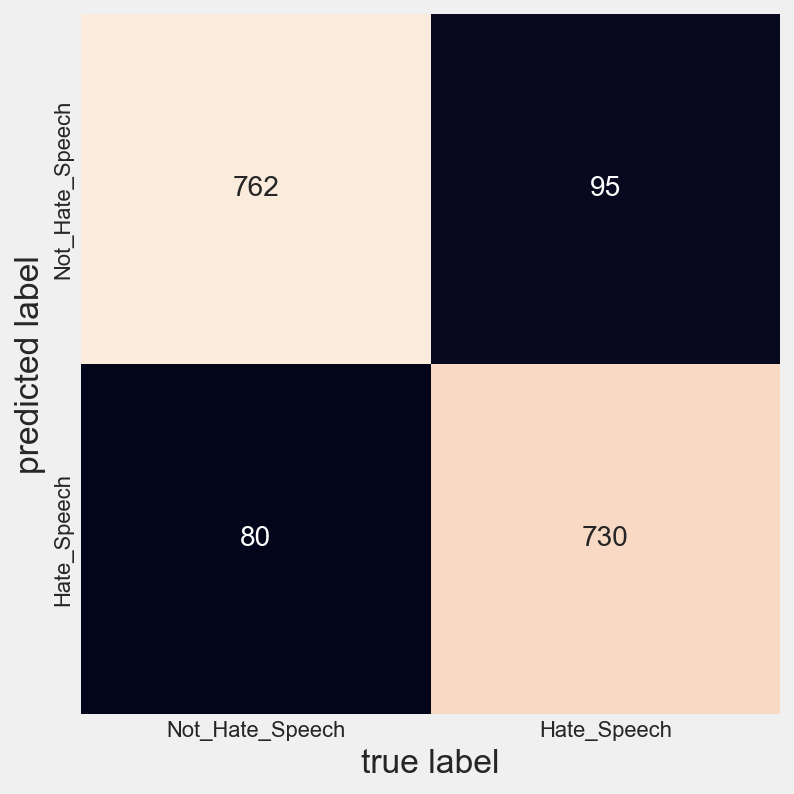

In [55]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, logreg_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [56]:
eval_metrics_dict['Logistic Regression Baseline'] = {'precision' : '{:.4}'.format(log_precision), 'recall': '{:.4}'.format(log_recall), 'f1-score': '{:.4}'.format(log_f1_score) }

## Naive Bayes Baseline

In [57]:
nb = MultinomialNB()
nb.fit(tfidf_data_train_lem, y_train_lem)
nb_test_preds = nb.predict(tfidf_data_test_lem)

In [58]:
nb_precision = precision_score(y_test_lem, nb_test_preds)
nb_recall = recall_score(y_test_lem, nb_test_preds)
nb_acc_score = accuracy_score(y_test_lem, nb_test_preds)
nb_f1_score = f1_score(y_test_lem, nb_test_preds)
print('Random Forest with Lemmatization Features:')

print('Precision: {:.4}'.format(nb_precision))
print('Recall: {:.4}'.format(nb_recall))

print("Testing Accuracy: {:.4}".format(nb_acc_score))
print("F1 Score: {:.4}".format(nb_f1_score))

Random Forest with Lemmatization Features:
Precision: 0.8753
Recall: 0.9273
Testing Accuracy: 0.8986
F1 Score: 0.9005


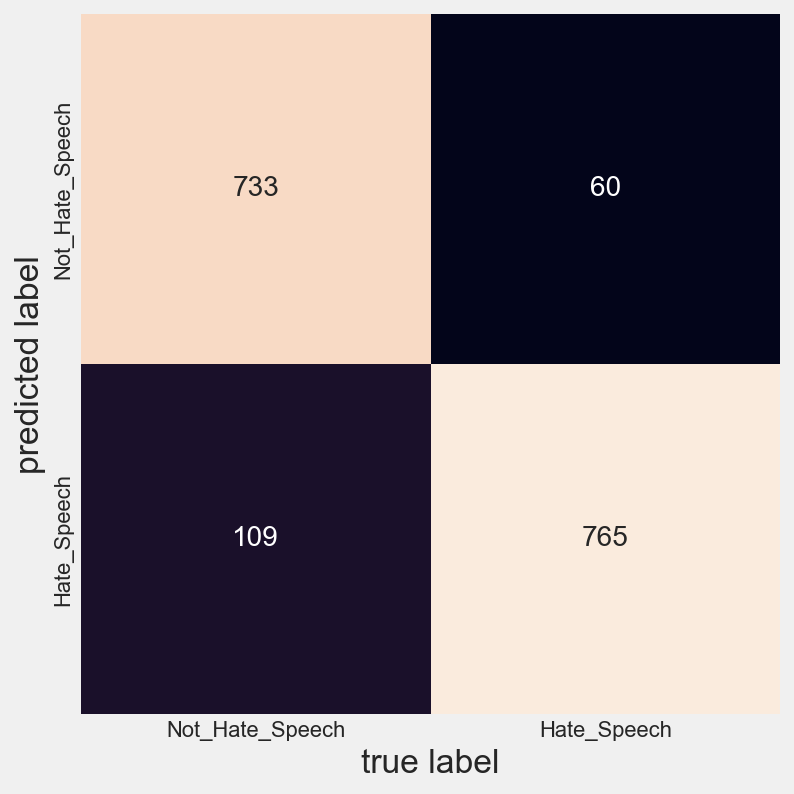

In [59]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, nb_test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [60]:
eval_metrics_dict['Naive Bayes Baseline'] = {'precision' : '{:.4}'.format(nb_precision), 'recall': '{:.4}'.format(nb_recall), 'f1-score': '{:.4}'.format(nb_f1_score) }

## Comparision

In [61]:
baseline_results = pd.DataFrame(eval_metrics_dict).T

In [62]:
baseline_results

,precision,recall,f1-score
Random Forest Baseline,0.8685,0.9285,0.8975
Logistic Regression Baseline,0.9012,0.8848,0.893
Naive Bayes Baseline,0.8753,0.9273,0.9005


###  As our major evaluation metricks will be Recall and F1 score, based on models perfomance - best results was achived with random forest 

# Tuning Model

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
# Number of trees in random forrest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num =5)]

# number of features to consider at each split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [2,4]

# min number of samples required to splid the node
min_samples_split =[2,5]

# min number of samples required at each leaf node
min_samples_leaf =[1,2]

#Method of selecting samples for training each tree
# bootstrap =[True,False]

In [65]:
param_grid = {'n_estimators' : n_estimators,
             'max_features' : max_features,
             'max_depth' : max_depth,
             'min_samples_split' : min_samples_split,
             'min_samples_leaf' : min_samples_leaf}
             #'bootstrap' : bootstrap }
param_grid

{'n_estimators': [50, 87, 125, 162, 200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 4],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2]}

In [66]:
rf_momdel = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf_momdel, param_grid = param_grid, cv = 3, verbose = 3, n_jobs = 4, scoring = 'recall' )

In [67]:
rf_grid.fit(tfidf_data_train_lem, y_train_lem)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4], 'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 87, 125, 162, 200]},
             scoring='recall', verbose=3)

In [68]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [69]:
rf_clf_tunned = RandomForestClassifier(n_estimators = 100, max_depth = 2, max_features = 'auto', min_samples_split=2)
rf_clf_tunned.fit(tfidf_data_train_lem, y_train_lem)
t_rf_test_preds_lem = rf_clf_tunned.predict(tfidf_data_test_lem)

In [70]:
t_rf_precision = precision_score(y_test_lem, t_rf_test_preds_lem)
t_rf_recall = recall_score(y_test_lem, t_rf_test_preds_lem)
t_rf_acc_score = accuracy_score(y_test_lem, t_rf_test_preds_lem)
t_rf_f1_score = f1_score(y_test_lem, t_rf_test_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision))
print('Recall: {:.4}'.format(t_rf_recall))

print("Testing Accuracy: {:.4}".format(t_rf_acc_score))
print("F1 Score: {:.4}".format(t_rf_f1_score))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.8271
Recall: 0.7188
Testing Accuracy: 0.7864
F1 Score: 0.7691


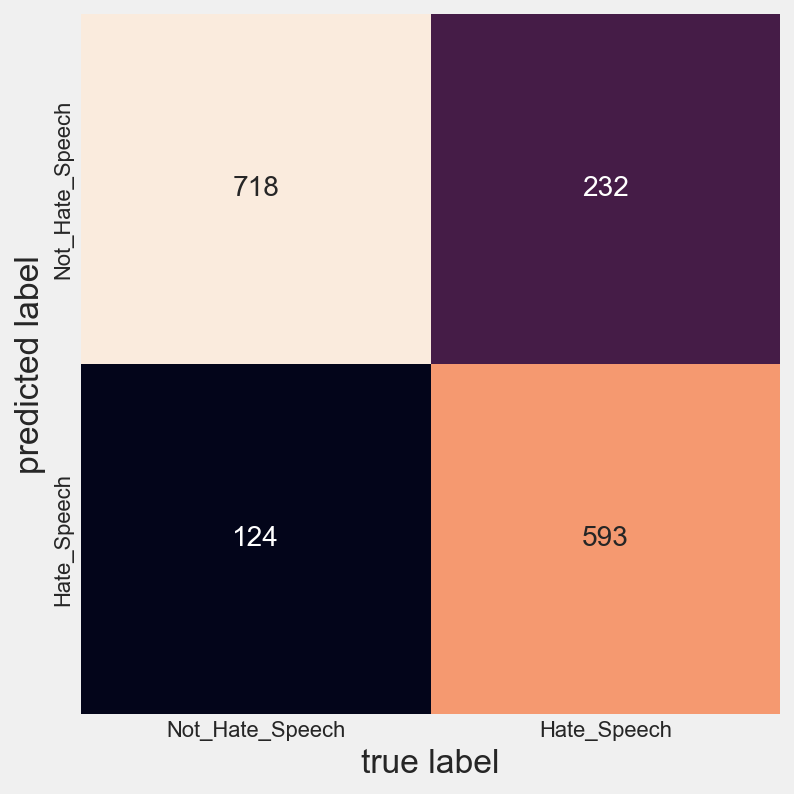

In [71]:
fig, ax = plt.subplots(figsize=(6,6))
mat = confusion_matrix(y_test_lem, t_rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Hate_Speech', 'Hate_Speech'], yticklabels=['Not_Hate_Speech', 'Hate_Speech'])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()


In [72]:
t_rf_train_preds_lem = rf_clf_tunned.predict(tfidf_data_train_lem)

t_rf_precision_train = precision_score(y_train_lem, t_rf_train_preds_lem)
t_rf_recall_train = recall_score(y_train_lem, t_rf_train_preds_lem)
t_rf_acc_score_train = accuracy_score(y_train_lem, t_rf_train_preds_lem)
t_rf_f1_score_train = f1_score(y_train_lem, t_rf_train_preds_lem)
print('Random Forest with Hyper Parameters selected with GridSearch:')

print('Precision: {:.4}'.format(t_rf_precision_train))
print('Recall: {:.4}'.format(t_rf_recall_train))

print("Training Accuracy: {:.4}".format(t_rf_acc_score_train))
print("F1 Score: {:.4}".format(t_rf_f1_score_train))

Random Forest with Hyper Parameters selected with GridSearch:
Precision: 0.8753
Recall: 0.7195
Training Accuracy: 0.8077
F1 Score: 0.7898
